In [4]:
def cosamp(Phi, u, s, tol=1e-10, max_iter=1000):
    """
    @Brief:  "CoSaMP: Iterative signal recovery from incomplete and inaccurate
             samples" by Deanna Needell & Joel Tropp

    @Input:  Phi - Sampling matrix
             u   - Noisy sample vector
             s   - Sparsity

    @Return: <array> An s-sparse approximation "a" of the target signal
    """
    max_iter -= 1 # Correct the while loop
    num_precision = 1e-12
    a = np.zeros(Phi.shape[1])
    v = u
    iter = 0
    halt = False
    while not halt:
        iter += 1
        print("Iteration {}\r".format(iter))
        
        y = abs(np.dot(np.transpose(Phi), v))
        Omega = [i for (i, val) in enumerate(y) if val > np.sort(y)[::-1][2*s] and val > num_precision] # quivalent to below
        #Omega = np.argwhere(y >= np.sort(y)[::-1][2*s] and y > num_precision)
        T = np.union1d(Omega, a.nonzero()[0])
        #T = np.union1d(Omega, T)
        b = np.dot( np.linalg.pinv(Phi[:,T]), u )
        igood = (abs(b) > np.sort(abs(b))[::-1][s]) & (abs(b) > num_precision)
        T = T[igood]
        a[T] = b[igood]
        v = u - np.dot(Phi[:,T], b[igood])
        
        halt = np.linalg.norm(v)/np.linalg.norm(u) < tol or \
               iter > max_iter
        
    return a

Test the cosamp Python method in the reconstruction of a high-frequency signal from sparse measurements:

Iteration 1


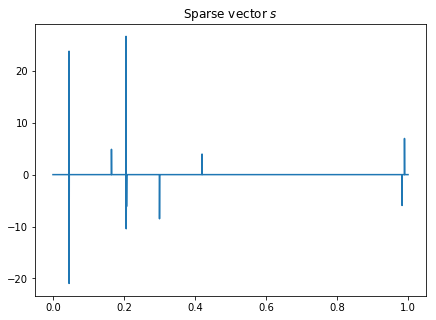

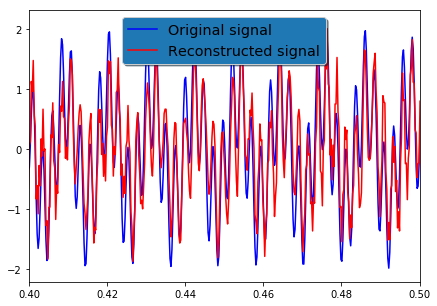

In [10]:
import numpy as np
import scipy.linalg
import scipy.signal
import matplotlib.pyplot as plt

n = 4000 # number of measurements
t = np.linspace(0.0, 1.0, num=n)

x = np.sin(91*2*np.pi*t) + np.sin(412*2*np.pi*t) # original signal (to be reconstructed)

# randomly sample signal
p = 103 # random sampling (Note that this is one eighth of the Shannon–Nyquist rate!)
aquis = np.round((n-1) * np.random.rand(p)).astype(int)
y = x[aquis] # our compressed measurement from the random sampling

# Here {y} = [C]{x} = [C][Phi]{s}, where Phi is the inverse discrete cosine transform

Phi = scipy.fftpack.dct(np.eye(n), axis=0, norm='ortho')
CPhi = Phi[aquis,:]

# l1 minimization (through linear programming)
s = cosamp(CPhi, y, 10) # obtain the sparse vector through CoSaMP algorithm
xrec = scipy.fftpack.idct(s, axis=0, norm='ortho') # Reconstructed signal



figw, figh = 7.0, 5.0 # figure width and height
plt.figure(figsize=(figw, figh))
plt.plot(t, s)
plt.title('Sparse vector $s$')
plt.show()


# Visualize the compressed-sensing reconstruction signal
figw, figh = 7.0, 5.0 # figure width and height
plt.figure(figsize=(figw, figh))
plt.plot(t, x,    'b', label='Original signal')
plt.plot(t, xrec, 'r', label='Reconstructed signal')
plt.xlim(0.4, 0.5)
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')
plt.show()